In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
class SelfOrganizingMap:
    def __init__(self, width, height, input_dim):
        self.width = width
        self.height = height
        self.input_dim = input_dim
        self.weights = np.random.rand(width, height, input_dim)
        self.history = []
        self._init_map()

    def _init_map(self):
        self.grid_x, self.grid_y = np.meshgrid(np.arange(self.width), np.arange(self.height))
        self.grid_x = self.grid_x.flatten()
        self.grid_y = self.grid_y.flatten()
        self.grid = np.column_stack((self.grid_x, self.grid_y))
        self.grid = np.array(self.grid, dtype=np.float32)
        self.grid = MinMaxScaler().fit_transform(self.grid)

    def find_bmu(self, x):
        distances = np.linalg.norm(self.weights - x, axis=2)
        bmu_index = np.unravel_index(np.argmin(distances), distances.shape)
        return bmu_index
    
    def gaussian(self, dist, sigma):
        return np.exp(-dist**2 / (2 * sigma**2))

    def neg_second_gaussian(self, dist, sigma):
        return (dist**2 / sigma**4 - 1 / sigma**2) * np.exp(-dist**2 / (2 * sigma**2))

    
    def train(self, data, epochs, learning_rate, lambda_decay=10, sigma_param=1.0, dist_fun="gaussian"):
        for epoch in range(epochs):
            alpha = learning_rate * np.exp(-epoch / lambda_decay)
            for x in data:
                bmu_index = self.find_bmu(x)
                bmu_coords = np.array(bmu_index)

                # Odległość siatki neuronów od BMU
                neuron_coords = np.dstack(np.meshgrid(np.arange(self.width), np.arange(self.height))).reshape(-1, 2)
                dists = np.linalg.norm(neuron_coords - bmu_coords, axis=1)

                # Funkcja sąsiedztwa
                if dist_fun == "gaussian":
                    neighborhood = self.gaussian(dists * sigma_param, sigma=1.0)
                elif dist_fun == "neg_gaussian":
                    neighborhood = self.neg_second_gaussian(dists * sigma_param, sigma=1.0)
                else:
                    neighborhood = np.ones_like(dists)

                # Aktualizacja wag
                for idx, (i, j) in enumerate(neuron_coords):
                    self.weights[i, j] += alpha * neighborhood[idx] * (x - self.weights[i, j])
            self.history.append(np.copy(self.weights))
            
    def plot_map(self, data):
        plt.figure(figsize=(8, 8))

        # Wagi neuronów - przekształcamy z (width, height, input_dim) do (n_neurons, input_dim)
        neuron_weights = self.weights.reshape(-1, self.input_dim)

        # Rysujemy punkty danych
        plt.scatter(data[:, 0], data[:, 1], c='blue', label='Dane')

        # Rysujemy wagi neuronów
        plt.scatter(neuron_weights[:, 0], neuron_weights[:, 1], c='red', marker='x', label='Neurony SOM')

        # Rysujemy linie między sąsiednimi neuronami (opcjonalnie)
        for i in range(self.width):
            for j in range(self.height):
                idx = i * self.height + j
                if i < self.width - 1:
                    right = (i+1) * self.height + j
                    plt.plot(
                        [neuron_weights[idx, 0], neuron_weights[right, 0]],
                        [neuron_weights[idx, 1], neuron_weights[right, 1]],
                        'gray', linewidth=0.5
                    )
                if j < self.height - 1:
                    below = i * self.height + (j+1)
                    plt.plot(
                        [neuron_weights[idx, 0], neuron_weights[below, 0]],
                        [neuron_weights[idx, 1], neuron_weights[below, 1]],
                        'gray', linewidth=0.5
                    )

        plt.title('Mapa wag neuronów SOM')
        plt.legend()
        plt.grid(True)
        plt.show()



    def plot_clusters(self, data):
        plt.figure(figsize=(10, 10))
        plt.scatter(data[:, 0], data[:, 1], c='blue', marker='o', label='Data Points')
        plt.scatter(self.grid[:, 0], self.grid[:, 1], c='red', marker='x', label='SOM Weights')
        plt.title('Clusters in Self-Organizing Map')
        plt.legend()
        plt.show()

    def animate_training(self, data):
        fig, ax = plt.subplots(figsize=(8, 8))

        scatter_data = ax.scatter(data[:, 0], data[:, 1], c='blue', label='Dane')
        scatter_weights = ax.scatter([], [], c='red', marker='x', label='Neurony SOM')

        ax.set_title('Trenowanie SOM – animacja')
        ax.legend()
        ax.grid(True)

        def init():
            scatter_weights.set_offsets([])
            return scatter_weights,

        def update(frame):
            weights = self.history[frame].reshape(-1, self.input_dim)
            scatter_weights.set_offsets(weights[:, :2])
            ax.set_title(f'Epoka {frame+1}/{len(self.history)}')
            return scatter_weights,

        ani = animation.FuncAnimation(fig, update, frames=len(self.history),
                                    init_func=init, blit=True, interval=200)
        plt.close(fig)  # zapobiega podwójnemu wyświetleniu
        return HTML(ani.to_jshtml())


In [ ]:
data_hexagon = pd.read_csv('dane_koh/mio2/hexagon.csv')
X_hexagon = data_hexagon[['x', 'y']]
y_hexagon = data_hexagon['c']

In [18]:
som = SelfOrganizingMap(width=4, height=4, input_dim=2)
som.train(X_hexagon.values, epochs=100, learning_rate=0.1, dist_fun="gaussian")

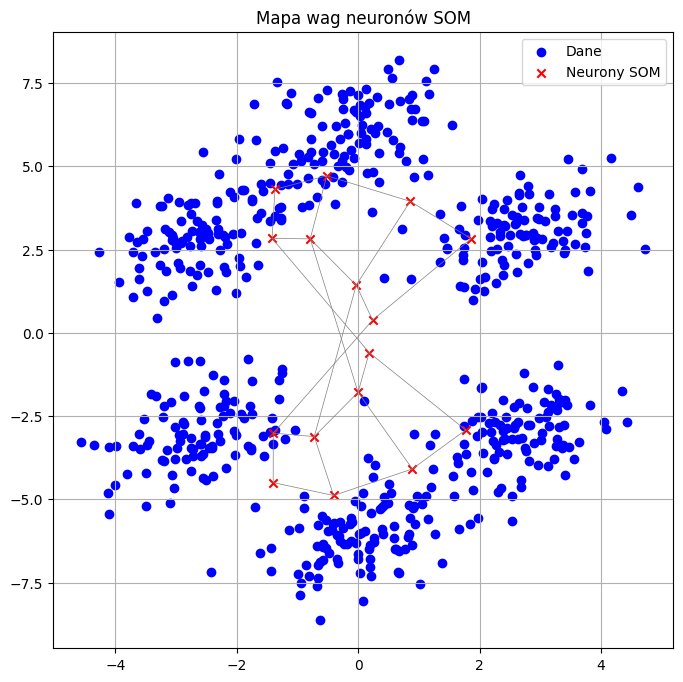

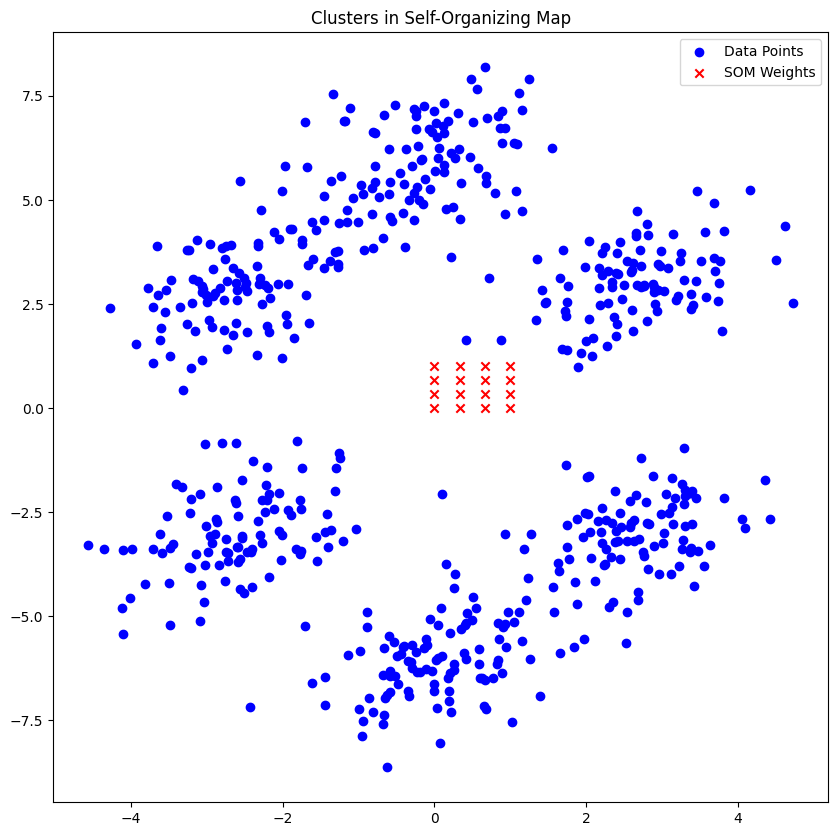

Neuron (np.int64(3), np.int64(0)): {np.int64(1): 91}
Neuron (np.int64(1), np.int64(0)): {np.int64(0): 87}
Neuron (np.int64(0), np.int64(3)): {np.int64(1): 1, np.int64(2): 85}
Neuron (np.int64(3), np.int64(3)): {np.int64(3): 1, np.int64(4): 19}
Neuron (np.int64(2), np.int64(2)): {np.int64(4): 1}
Neuron (np.int64(2), np.int64(3)): {np.int64(2): 1, np.int64(3): 83}
Neuron (np.int64(0), np.int64(1)): {np.int64(5): 72}
Neuron (np.int64(3), np.int64(2)): {np.int64(4): 75}
Neuron (np.int64(0), np.int64(0)): {np.int64(0): 6, np.int64(5): 28}
Neuron (np.int64(2), np.int64(0)): {np.int64(0): 7, np.int64(1): 5}
Neuron (np.int64(1), np.int64(3)): {np.int64(2): 14, np.int64(3): 16}
Neuron (np.int64(2), np.int64(1)): {np.int64(1): 2}
Neuron (np.int64(1), np.int64(2)): {np.int64(4): 4}
Neuron (np.int64(0), np.int64(2)): {np.int64(4): 1}
Neuron (np.int64(3), np.int64(1)): {np.int64(1): 1}


In [20]:
som.plot_map(X_hexagon.values)
som.plot_clusters(X_hexagon.values)
som.evaluate_clustering(X_hexagon.values, y_hexagon.values)